In [74]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [76]:
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split

from source.config import *
from source.classic_stability_analyzer import ClassicStabilityAnalyzer

In [77]:
sns.set(rc={'figure.figsize':(15, 5)})
dataset_name = 'folktables'
state = 'LA'
extended_dataset_name = f"{dataset_name}_{state}"
dataset_config = DATASETS_CONFIG[dataset_name]
TARGET_COLUMN = dataset_config['target_column']

In [78]:
# Creating a data frame
df = pd.read_csv(f"../../datasets/folktables-{state}-2018.csv", delimiter=',')
df.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,29,18,5,16,2,0,1,1,4,2,1,2,2,2,1,1,0
1,17,13,5,16,2,0,1,1,4,1,1,2,2,2,1,2,0
2,37,13,5,16,2,0,1,1,4,1,1,2,2,2,1,1,0
3,86,12,2,16,1,0,1,1,4,1,1,2,1,2,2,2,0
4,22,19,5,17,2,0,1,1,4,1,1,2,2,2,2,1,0


In [79]:
df.shape

(43588, 17)

In [80]:
df.columns

Index(['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC',
       'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR'],
      dtype='object')

In [81]:
df['ESR'].value_counts()

0    25363
1    18225
Name: ESR, dtype: int64

In [82]:
numerical_features = dataset_config['numerical_features']
categorical_features = [feature for feature in df.columns if feature not in numerical_features + [TARGET_COLUMN]]

categorical_features

['MAR',
 'RELP',
 'DIS',
 'ESP',
 'CIT',
 'MIG',
 'MIL',
 'ANC',
 'NATIVITY',
 'DEAR',
 'DEYE',
 'DREM',
 'SEX',
 'RAC1P']

### Apply data transformations

In [83]:
from sklearn.preprocessing import StandardScaler
from source.utils.simple_utils import make_feature_df


def transform_df(df, categorical_columns, numerical_columns):
    dataset_size = df.shape[0]
    test_size = int(TEST_FRACTION * dataset_size)
    validation_size = test_size
    train_cv_df, test_df = train_test_split(df, test_size=test_size, random_state=SEED)
    train_df, cv_df = train_test_split(train_cv_df, test_size=validation_size, random_state=SEED)

    train_feature_df = make_feature_df(train_df, categorical_columns, numerical_columns)
    cv_feature_df = make_feature_df(cv_df, categorical_columns, numerical_columns)
    test_feature_df = make_feature_df(test_df, categorical_columns, numerical_columns)

    scaler = StandardScaler()
    train_feature_df[train_feature_df.columns] = scaler.fit_transform(train_feature_df[train_feature_df.columns])
    cv_feature_df[cv_feature_df.columns] = scaler.transform(cv_feature_df[cv_feature_df.columns])
    test_feature_df[test_feature_df.columns] = scaler.transform(test_feature_df[test_feature_df.columns])

    train_feature_df[TARGET_COLUMN] = train_df[TARGET_COLUMN]
    cv_feature_df[TARGET_COLUMN] = cv_df[TARGET_COLUMN]
    test_feature_df[TARGET_COLUMN] = test_df[TARGET_COLUMN]
    print("train_feature_df shape: ", train_feature_df.shape)
    print("cv_feature_df shape: ", cv_feature_df.shape)
    print("test_feature_df shape: ", test_feature_df.shape)

    return train_feature_df, cv_feature_df, test_feature_df


In [84]:
train_df, cv_df, test_df = transform_df(df, categorical_features, numerical_features)

train_feature_df shape:  (26154, 74)
cv_feature_df shape:  (8717, 74)
test_feature_df shape:  (8717, 74)


### Analyze stability of Adaptive Random Forest classifier

In [85]:
from xgboost import XGBClassifier


def get_evaluation_model():
    # Set hyper-parameters for the best model. Use hyper-parameters, which were tuned on a drop-column dataset
    model_name = 'XGBClassifier'
    ML_baseline_results_df = pd.read_csv(os.path.join('..', '..', 'results', f'ML_baseline_results_{extended_dataset_name}.csv'))
    hyperparameters_dict = eval(ML_baseline_results_df.loc[ML_baseline_results_df['Model_Name'] == model_name,
                                                           'Model_Best_Params'].iloc[0])
    return model_name, XGBClassifier(
                            learning_rate=hyperparameters_dict['learning_rate'],
                            max_depth=hyperparameters_dict['max_depth'],
                            objective=hyperparameters_dict['objective'],
                            n_estimators=hyperparameters_dict['n_estimators']
                        )

In [86]:
y_train = train_df[TARGET_COLUMN]
X_train = train_df.drop([TARGET_COLUMN], axis=1)

In [87]:
base_model_name, base_model = get_evaluation_model()

# Conduct model training
base_model = base_model.fit(X_train, y_train)

In [88]:
stability_analyzer =  ClassicStabilityAnalyzer(base_model,
                                               base_model_name=base_model_name,
                                               train_pd_dataset=cv_df,
                                               test_pd_dataset=test_df,
                                               test_y_true=test_df[TARGET_COLUMN],
                                               dataset_name=dataset_name + '_LA',
                                               target_column=TARGET_COLUMN,
                                               n_estimators=100)

2022-11-17 16:08:48 classic_stability_analyzer.py INFO    : Start testing of classifier 1 / 100
2022-11-17 16:08:49 classic_stability_analyzer.py INFO    : Classifier 1 / 100 was tested
2022-11-17 16:08:49 classic_stability_analyzer.py INFO    : Start testing of classifier 2 / 100
2022-11-17 16:08:49 classic_stability_analyzer.py INFO    : Classifier 2 / 100 was tested
2022-11-17 16:08:49 classic_stability_analyzer.py INFO    : Start testing of classifier 3 / 100
2022-11-17 16:08:50 classic_stability_analyzer.py INFO    : Classifier 3 / 100 was tested
2022-11-17 16:08:50 classic_stability_analyzer.py INFO    : Start testing of classifier 4 / 100
2022-11-17 16:08:51 classic_stability_analyzer.py INFO    : Classifier 4 / 100 was tested
2022-11-17 16:08:51 classic_stability_analyzer.py INFO    : Start testing of classifier 5 / 100
2022-11-17 16:08:51 classic_stability_analyzer.py INFO    : Classifier 5 / 100 was tested
2022-11-17 16:08:51 classic_stability_analyzer.py INFO    : Start test

General Ensemble Accuracy: 0.1814
Mean: 0.5839999914169312
Std: 0.04740000143647194
IQR: 0.0613
Per sample accuracy: 0.1874
Label stability: 0.9223
Jitter: 1.0




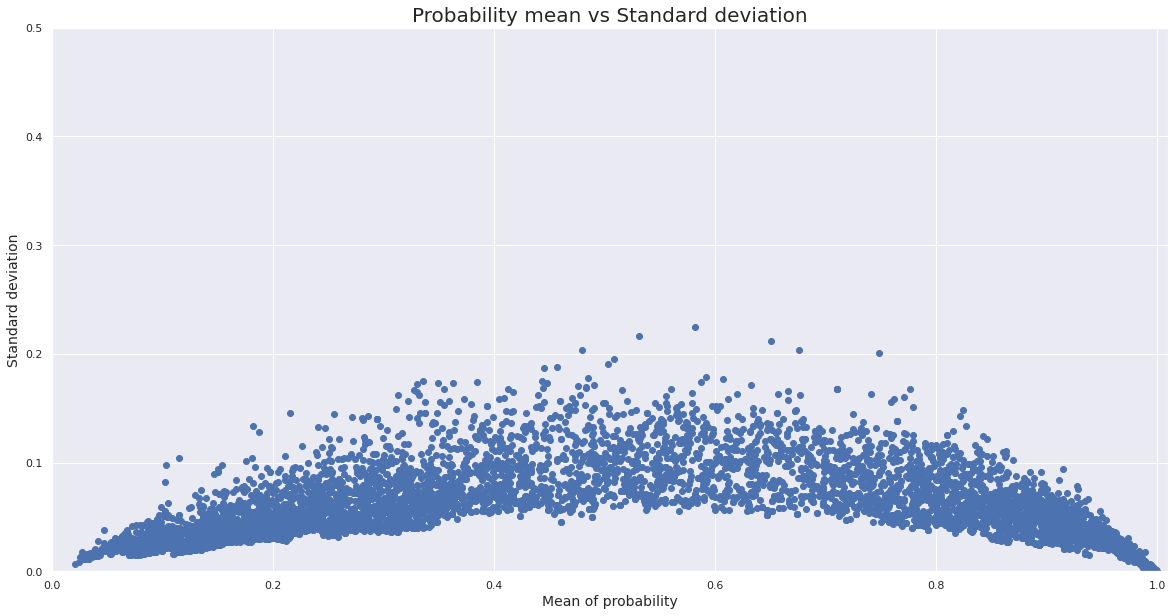

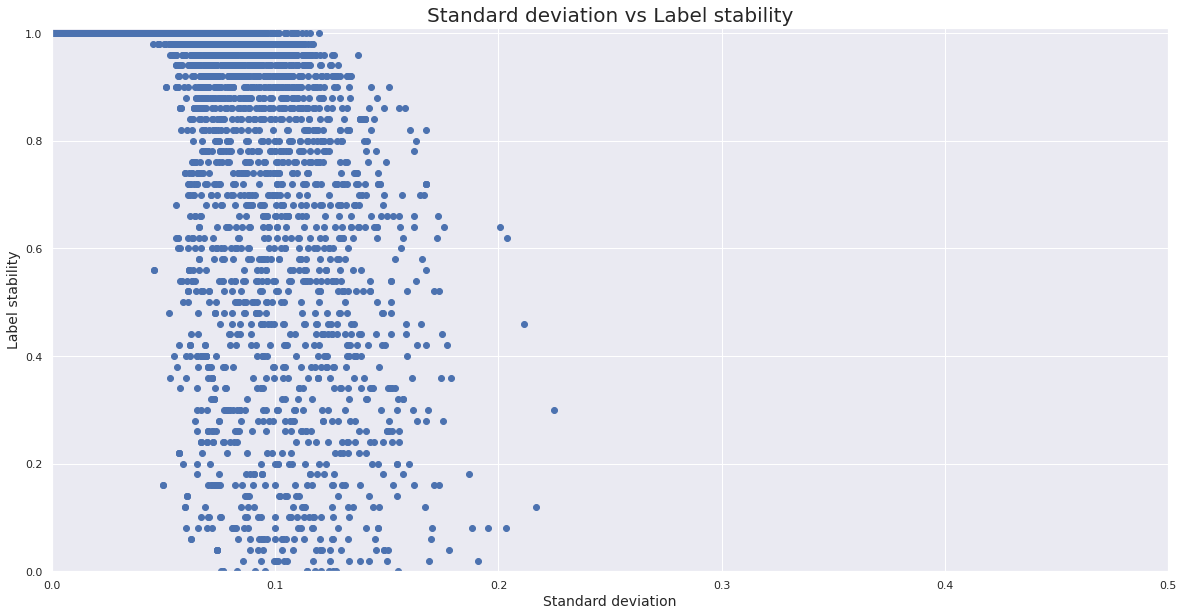

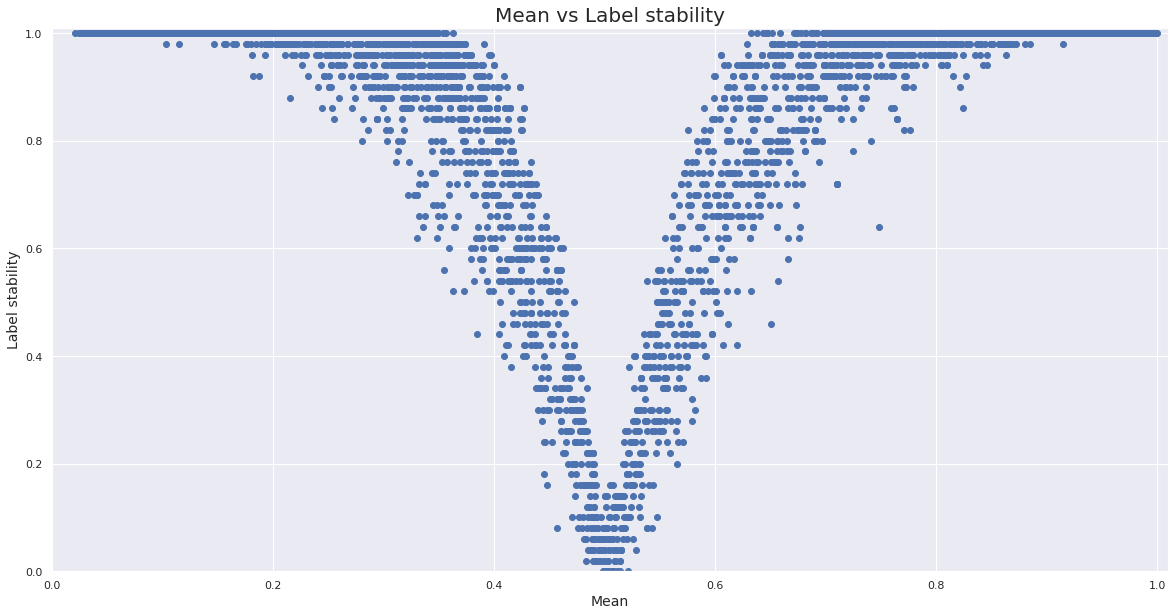

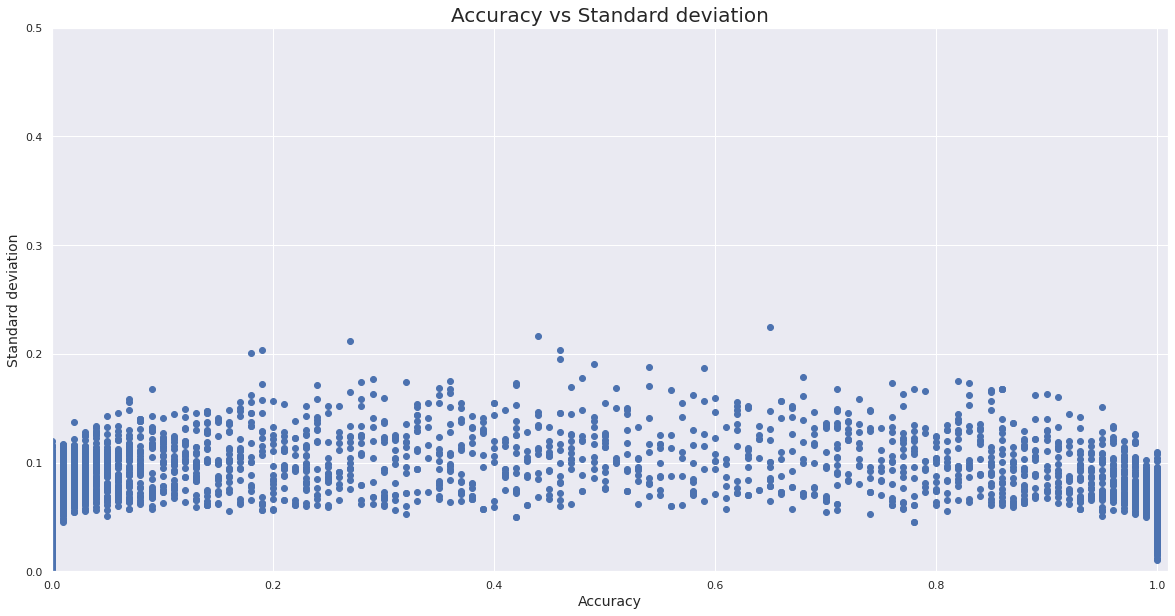

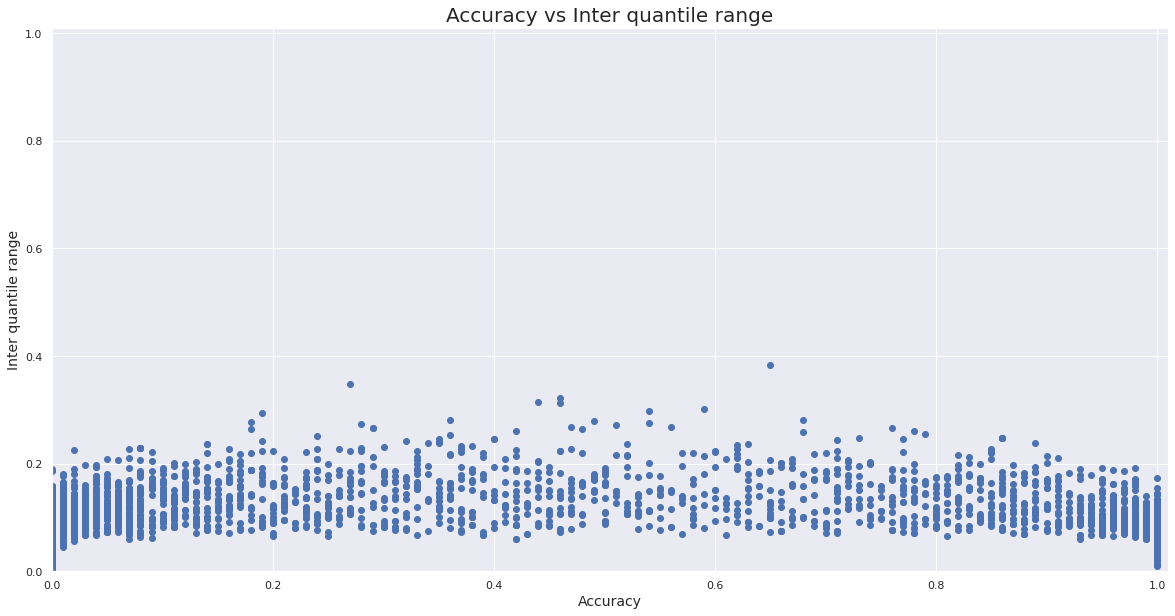

In [89]:
stability_analyzer.measure_stability_metrics(make_plots=True)